# scVI with Pyro


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import broadcast_all, probs_to_logits, lazy_property, logits_to_probs

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

import collections
from numbers import Number
from typing import Iterable

import numpy as np
import pandas as pd
import anndata

from scvi.dataset import GeneExpressionDataset

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
# NegativeBinomial distribution is not in the current version of PyTorch so I reimplemented it

class _GreaterThanEq(constraints.Constraint):
    """
    Constrain to a real half line `[lower_bound, inf)`.
    """
    def __init__(self, lower_bound):
        self.lower_bound = lower_bound

    def check(self, value):
        return self.lower_bound <= value

class _HalfOpenInterval(constraints.Constraint):
    """
    Constrain to a real interval `[lower_bound, upper_bound)`.
    """
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def check(self, value):
        return (self.lower_bound <= value) & (value < self.upper_bound)


class NegativeBinomial(torch.distributions.Distribution,
                       pyro.distributions.torch.TorchDistributionMixin):
    r"""
    Creates a Negative Binomial distribution parameterized by `total_count` and
    either `probs` or `logits` (but not both). `total_count` must be
    broadcastable with `probs`/`logits`.
    :param (Tensor) total_count: number of Bernoulli trials
    :param (Tensor) probs: Event probabilities
    :param (Tensor) logits: Event log-odds
    """
    arg_constraints = {'total_count': _GreaterThanEq(0),
                       'probs': _HalfOpenInterval(0., 1.)}
    support = constraints.nonnegative_integer

    def __init__(self, total_count, probs=None, logits=None, validate_args=None):
        if (probs is None) == (logits is None):
            raise ValueError("Either `probs` or `logits` must be specified, but not both.")
        if probs is not None:
            self.total_count, self.probs, = broadcast_all(total_count, probs)
            self.total_count = self.total_count.type_as(self.probs)
            is_scalar = isinstance(self.probs, Number)
        else:
            self.total_count, self.logits, = broadcast_all(total_count, logits)
            self.total_count = self.total_count.type_as(self.logits)
            is_scalar = isinstance(self.logits, Number)

        self._param = self.probs if probs is not None else self.logits
        if is_scalar:
            batch_shape = torch.Size()
        else:
            batch_shape = self._param.shape
        super(NegativeBinomial, self).__init__(batch_shape, validate_args=validate_args)

    def _new(self, *args, **kwargs):
        return self._param.new(*args, **kwargs)

    @property
    def mean(self):
        return self.total_count * self.probs

    @property
    def variance(self):
        return self.total_count * self.probs * (1 - self.probs)

    @lazy_property
    def logits(self):
        return probs_to_logits(self.probs, is_binary=True)

    @lazy_property
    def probs(self):
        return logits_to_probs(self.logits, is_binary=True)

    @property
    def param_shape(self):
        return self._param.shape

    @lazy_property
    def _gamma(self):
        return torch.distributions.Gamma(concentration=self.total_count,
                                         rate=torch.exp(-self.logits))

    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            rate = self._gamma.sample(sample_shape=sample_shape)
            return torch.poisson(rate)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)

        log_unnormalized_prob = (self.total_count * F.logsigmoid(-self.logits)
                                 + value * F.logsigmoid(self.logits))

        log_normalization = (-torch.lgamma(self.total_count + value)
                             + torch.lgamma(self.total_count)
                             + torch.lgamma(1. + value))

        return log_unnormalized_prob - log_normalization

    def expand(self, batch_shape):
        try:
            return super(NegativeBinomial, self).expand(batch_shape)
        except NotImplementedError:
            validate_args = self.__dict__.get('_validate_args')
            total_count = self.total_count.expand(batch_shape)
            if 'probs' in self.__dict__:
                probs = self.probs.expand(batch_shape)
                return type(self)(total_count, probs=probs, validate_args=validate_args)
            else:
                logits = self.logits.expand(batch_shape)
                return type(self)(total_count, logits=logits, validate_args=validate_args)

In [7]:
# class for creating a bunch of fully connected layers
# (taken from https://github.com/YosefLab/scVI/blob/master/scvi/models/modules.py)

class FCLayers(nn.Module):
    """
    n_in : int 
        shape of input data
    n_out : int
        shape of output data
    n_layers : int
        number of hidden layers
    n_hidden : int
        nodes in the hidden layers
    dropout_rate : float
        dropout rate for edges (when training)
    """
    def __init__(self, n_in, n_out, n_layers=1, n_hidden=128, dropout_rate=0.1):
        super(FCLayers, self).__init__()
        layers_dim = [n_in] + (n_layers - 1) * [n_hidden] + [n_out]
        self.fc_layers = nn.Sequential(collections.OrderedDict(
            [('Layer {}'.format(i), nn.Sequential(
                nn.Linear(n_in, n_out),
                nn.BatchNorm1d(n_out, eps=1e-3, momentum=0.99),
                nn.ReLU(),
                nn.Dropout(p=dropout_rate)
            )) for i, (n_in, n_out) in enumerate(zip(layers_dim[:-1], layers_dim[1:]))]))

    def forward(self, x):
        for layers in self.fc_layers:
            for layer in layers:
                if isinstance(layer, nn.BatchNorm1d) and x.dim() == 3:
                    x = torch.cat([(layer(slice_x)).unsqueeze(0) for slice_x in x], dim=0)
                else:
                    x = layer(x)
        return x


In [8]:
# this is scvi.models.modules.DecoderSCVI minus some stuff for batch effects
# which I took out for simplicity
# taken from https://github.com/YosefLab/scVI/blob/master/scvi/models/modules.py


class DecoderSCVI(nn.Module):
    r"""Decodes data from latent space of ``n_input`` dimensions ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (latent space)
    :param n_output: The dimensionality of the output (data space)
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :param dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int, n_layers: int = 1,
                 n_hidden: int = 128, dropout_rate: float = 0.1):
        super(DecoderSCVI, self).__init__()
        self.px_decoder = FCLayers(n_in=n_input, n_out=n_hidden, n_layers=n_layers,
                                   n_hidden=n_hidden, dropout_rate=dropout_rate)

        # mean gamma
        self.px_scale_decoder = nn.Sequential(nn.Linear(n_hidden, n_output), 
                                              nn.Softmax(dim=-1))

        # dispersion: here we only deal with gene-cell dispersion case
        self.px_r_decoder = nn.Linear(n_hidden, n_output)

    def forward(self, z: torch.Tensor, library: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Decodes the data from the latent space using the decoder network
         #. Returns parameters for the ZINB distribution of expression
         #. If ``dispersion != 'gene-cell'`` then value for that param will be ``None``

        :param z: tensor with shape ``(n_input,)``
        :param library: library size
        :return: parameters for the ZINB distribution of expression
        :rtype: 4-tuple of :py:class:`torch.Tensor`
        """

        # The decoder returns values for the parameters of the NB distribution
        px = self.px_decoder(z)
        px_scale = self.px_scale_decoder(px)
        # Clamp to high value: exp(12) ~ 160000 to avoid nans (computational stability)
        px_rate = torch.exp(torch.clamp(library, max=12)) * px_scale
        px_r = self.px_r_decoder(px)
        return px_r, px_rate


In [9]:
# this is scvi.models.modules.Encoder, again minus batch effects

class Encoder(nn.Module):
    def __init__(self, n_input, n_output, n_layers=1, n_hidden=128, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.encoder = FCLayers(n_in=n_input, n_out=n_hidden, n_layers=n_layers,
                                n_hidden=n_hidden, dropout_rate=dropout_rate)
        self.mean_encoder = nn.Linear(n_hidden, n_output)
        self.var_encoder = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # Parameters for latent distribution
        q = self.encoder(x)
        q_m = self.mean_encoder(q)
        q_v = torch.exp(torch.clamp(self.var_encoder(q), -5, 5))  # (computational stability safeguard)
        return q_m, q_v


In [10]:
# adapted from the Pyro VAE tutorial (http://pyro.ai/examples/vae.html)
# but using the encoder and decoder modules from scVI as in
# https://github.com/YosefLab/scVI/blob/master/scvi/models/vae.py

class SCVAE(nn.Module):
    def __init__(self, n_input, z_dim=8, n_layers=3, hidden_dim=64, use_cuda=False):
        super(SCVAE, self).__init__()
        # create the encoder and decoder networks
        self.z_encoder = Encoder(n_input, z_dim, n_layers=n_layers, n_hidden=hidden_dim)
        self.l_encoder = Encoder(n_input, 1, n_layers=n_layers, n_hidden=hidden_dim)
        self.decoder = DecoderSCVI(z_dim, n_input, n_layers=n_layers, n_hidden=hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))

            l_loc = x.new_zeros(torch.Size((x.size(0), 1)))
            l_scale = x.new_ones(torch.Size((x.size(0), 1)))

            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale, validate_args=True).independent(1))
            l = pyro.sample("library", dist.Normal(l_loc, l_scale, validate_args=True).independent(1))
 
            # decode the latent code z
            px_r, px_rate = self.decoder.forward(z, l)

            # the scVI model uses a different parameterization of the NB distribution
            # so here I am converting to something the PyTorch version can use.
        
            # exp(px_r) = theta, px_rate = mu
            # p = mu / (mu + theta)
            # logit = log(p) - log(1 - p) 
            #       = log(mu) - log(mu + theta) - (log(theta) - log(mu + theta))
            #       = log(mu) - log(theta)
            px_logit = torch.log(px_rate) - px_r

            # score against data
            pyro.sample("obs", NegativeBinomial(total_count=torch.exp(px_r), logits=px_logit,
                                                validate_args=True).independent(1), obs=x)

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("z_encoder", self.z_encoder)
        pyro.module("l_encoder", self.l_encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.z_encoder.forward(x)
            l_loc, l_scale = self.l_encoder.forward(x)
            
            # sample the latent code z and library size
            pyro.sample("latent", dist.Normal(z_loc, z_scale, validate_args=True).independent(1))
            pyro.sample("library", dist.Normal(l_loc, l_scale, validate_args=True).independent(1))


## Testing SCVAE on real data

Data is available in a variety of places, e.g. s3://czbiohub-tabula-muris/

In [14]:
droplet_metadata = pd.read_csv('TM_droplet_metadata.csv', index_col=0, dtype=str)
tmd = anndata.read_h5ad('TM_droplet_mat.h5ad')

def get_droplet_tissue(tissue):
    tmd_scvi = GeneExpressionDataset(
        *GeneExpressionDataset.get_attributes_from_matrix(tmd.X),
        gene_names=np.array(tmd.var.values, dtype=str)
    )
    
    tissue_metadata = droplet_metadata.loc[((droplet_metadata['tissue'] == tissue).values
                                            & np.asarray(tmd_scvi.X.sum(1) > 1000).flatten()
                                            & np.asarray((tmd_scvi.X > 0).sum(1) > 500).flatten())]

    
    # downsample to cells that passed QC and were (mostly) annotated
    tmd_scvi.update_cells(np.where(droplet_metadata['tissue'] == tissue)[0])
    tmd_scvi.update_cells(np.where(tmd_scvi.X.sum(1) > 1000)[0])
    tmd_scvi.update_cells(np.where((tmd_scvi.X > 0).sum(1) > 500)[0])
    
    classes = sorted(lbl if lbl is not np.nan else 'na' 
                     for lbl in set(tissue_metadata['cell_ontology_class']))
    
    return tissue_metadata, tmd_scvi, classes

In [15]:

tissue_metadata, tmd_scvi, classes = get_droplet_tissue('Trachea')

tmd_scvi.X.shape, tissue_metadata.shape, classes

Downsampling from 70118 to 21384 cells
Downsampling from 21384 to 11386 cells
Downsampling from 11386 to 11269 cells


((11269, 23433),
 (11269, 8),
 ['blood cell',
  'endothelial cell',
  'epithelial cell',
  'mesenchymal cell',
  'neuroendocrine cell'])

In [17]:
# these were adapted from the Pyro VAE tutorial

def train(svi, train_loader, n_train, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = (xs[0].cuda(),)
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(xs[0])

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = (xs[0].cuda(),)
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(xs[0])

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker='o', label='Train ELBO')
    plt.plot(x[::test_int], test_elbo, marker='o', label='Test ELBO')
    plt.xlabel('Training Epoch')
    plt.legend()
    plt.show()


In [19]:
# to stop if I hit NaNs
import warnings
warnings.simplefilter("error")

In [20]:
pyro.validation_enabled(True)
pyro.clear_param_store() # need to do this before every run in a notebook

example_indices = np.random.permutation(len(tmd_scvi))
n_train = int(0.9 * len(tmd_scvi))  # 90%/10% train/test split
n_test = len(tmd_scvi) - n_train

data_loader_train = DataLoader(
    dataset=tmd_scvi, batch_size=64, pin_memory=True,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
    collate_fn=tmd_scvi.collate_fn
)
    
data_loader_test = DataLoader(
    dataset=tmd_scvi, batch_size=64, pin_memory=True,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
    collate_fn=tmd_scvi.collate_fn
)

# setup the VAE
vae = SCVAE(tmd_scvi.nb_genes, use_cuda=True, z_dim=10, n_layers=1, hidden_dim=128)

# setup the optimizer
optimizer = Adam({"lr": 1e-4})
# optimizer = SGD({'lr': 1e-6, 'momentum': 0.9, 'nesterov': True})


In [21]:
# setup the inference algorithm

# compare to https://github.com/YosefLab/scVI/tree/master/scvi/inference (!)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
test_iter = 5

# training loop
for epoch in range(21):
    total_epoch_loss_train = train(svi, data_loader_train, n_train, use_cuda=True)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test, use_cuda=True)
        test_elbo.append(-total_epoch_loss_test)

[epoch 000]  average training loss: 14337.5087
[epoch 005]  average training loss: 5347.3135
[epoch 010]  average training loss: 4987.7193
[epoch 015]  average training loss: 4880.3074
[epoch 020]  average training loss: 4833.1097


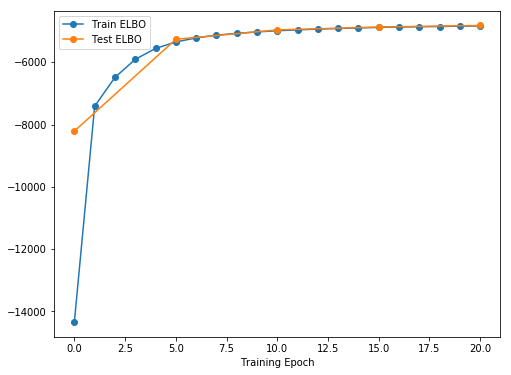

In [24]:
plot_llk(np.array(train_elbo), np.array(test_elbo), test_iter)